In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
metadata = pd.read_csv("../HAM10000_metadata.csv")
metadata.describe(include="all")

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0000835,ISIC_0028285,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [13]:
print(metadata.head(5))

     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [14]:
labels = list(metadata.dx.unique())
print(labels)

['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec']


nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64


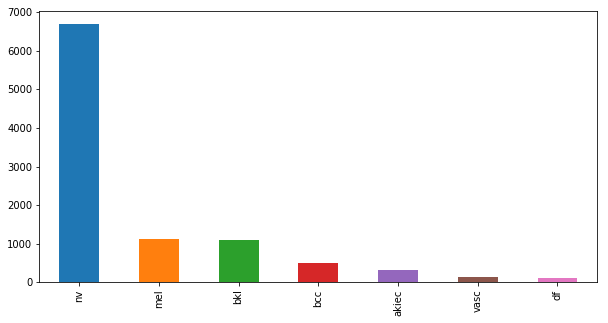

In [15]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
counts = metadata["dx"].value_counts()
print(counts)
counts.plot(kind='bar', ax=ax1)
#metadata["dx"].hist()

In [16]:
# parse out all classes to individual dataframes
nv = metadata[metadata["dx"] == "nv"]
nv.name = "nv"
mel = metadata[metadata["dx"] == "mel"]
mel.name = "mel"
bkl = metadata[metadata["dx"] == "bkl"]
bkl.name = "bkl"
bcc = metadata[metadata["dx"] == "bcc"]
bcc.name = "bcc"
akiec = metadata[metadata["dx"] == "akiec"]
akiec.name = "akiec"
vasc = metadata[metadata["dx"] == "vasc"]
vasc.name = "vasc"
df = metadata[metadata["dx"] == "df"]
df.name = "df"
# list out
classes = [nv, mel, bkl, bcc, akiec, vasc, df]

In [17]:
# preprocess accordingly
def preprocess(_image):
    #_image = cv2.cvtColor(_image, cv2.COLOR_BGR2RGB)
    
    #_image = cv2.equalizeHist(_image) 
    #_image = cv2.GaussianBlur(_image, (3,3), 1)
    _image = cv2.cvtColor(_image, cv2.COLOR_RGB2HSV)
    H,S,V = cv2.split(_image)
    _V = cv2.equalizeHist(V) 
    _image = cv2.merge([H, S, _V])
    _image = cv2.cvtColor(_image, cv2.COLOR_HSV2RGB)
    
    return _image

## Seperate into Respective Folders

In [18]:
import shutil
from sklearn.model_selection import train_test_split

# seperate images to each directory 
os.mkdir("ham_labled")
os.mkdir("ham_labled/train")
os.mkdir("ham_labled/test")

# each class
for _class in classes:
    _train, _test = train_test_split(_class, test_size = 0.2)
    print("Training: {}, Test: {} images found for class {}".format(len(_train), len(_test), _class.name))
    # train 
    os.mkdir("ham_labled/train/{}".format(_class.name))
    for i, row in _train.iterrows():
        image_id = row["image_id"]
        img = cv2.imread("../ham10000/{}.jpg".format(image_id))
        img = cv2.resize(img, (224, 224))
        cv2.imwrite("../ham10000/{}.jpg".format(image_id), img)
        shutil.move(
            src="../ham10000/{}.jpg".format(image_id), 
            dst="ham_labled/train/{}/".format(_class.name)
        )
    # test
    os.mkdir("ham_labled/test/{}".format(_class.name))
    for i, row in _test.iterrows():
        image_id = row["image_id"]
        img = cv2.imread("../ham10000/{}.jpg".format(image_id))
        img = cv2.resize(img, (224, 224))
        cv2.imwrite("../ham10000/{}.jpg".format(image_id), img)
        shutil.move(
            src="../ham10000/{}.jpg".format(image_id), 
            dst="ham_labled/test/{}/".format(_class.name)
        )
    print("Moving complete for class {}...".format(_class.name))

Training: 5364, Test: 1341 images found for class nv
Moving complete for class nv...
Training: 890, Test: 223 images found for class mel
Moving complete for class mel...
Training: 879, Test: 220 images found for class bkl
Moving complete for class bkl...
Training: 411, Test: 103 images found for class bcc
Moving complete for class bcc...
Training: 261, Test: 66 images found for class akiec
Moving complete for class akiec...
Training: 113, Test: 29 images found for class vasc
Moving complete for class vasc...
Training: 92, Test: 23 images found for class df
Moving complete for class df...


## Image Augumentation

Before we can start passing above images through a CNN feature extractor, we will augument images to address class imbalance problem and set a threshold of 5000 images per class.

In [19]:
from keras.preprocessing.image import ImageDataGenerator

_generator = ImageDataGenerator(
    width_shift_range=0.001,
    height_shift_range=0.001,
    zoom_range=0.01,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.99
)

Using TensorFlow backend.


In [20]:
from keras.preprocessing.image import img_to_array

def load_images(directory):
    images = [cv2.cvtColor(cv2.imread(os.path.join(directory, file)), cv2.COLOR_BGR2RGB)
              for file in os.listdir(directory)]
    images = [img_to_array(image, data_format="channels_last") for image in images]
    images = np.array(images)
    images = images.astype("float")
    return images
    

In [21]:
threshold = 3000
batch = 32
for _class in classes:
    _name = _class.name
    if len(_class) >= threshold:
        continue
    else:
        # what a pain ....PHEW!
        if os.path.exists("ham_labled/train/{}/.ipynb_checkpoints/".format(_name)):
            shutil.rmtree("ham_labled/train/{}/.ipynb_checkpoints/".format(_name))
        print("Augumenting images for class {}...".format(_name))
        X = load_images("ham_labled/train/{}/".format(_name))
        _auguments = _generator.flow(
            x=X,
            y=None,
            batch_size=batch,
            save_format="jpg",
            save_prefix="augumented",
            save_to_dir="ham_labled/train/{}/".format(_name)
        )
        for _ in range(int(np.ceil((threshold - X.shape[0])/batch))):
            x = next(_auguments)

Augumenting images for class mel...
Augumenting images for class bkl...
Augumenting images for class bcc...
Augumenting images for class akiec...
Augumenting images for class vasc...
Augumenting images for class df...


## Read the newly generated Images and process them accordingly

In [3]:
try:
    from imutils import paths
except ModuleNotFoundError:
    !pip install imutils
    from imutils import paths
import random
from sklearn.preprocessing import LabelEncoder

image_paths = list(paths.list_images("ham_labled/train"))
random.shuffle(image_paths)

labels = [cls.split(os.path.sep)[-2] for cls in image_paths]
le = LabelEncoder()
labels = le.fit_transform(labels)

print("{} total images found...".format(len(image_paths)))


  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /root/.cache/pip/wheels/b2/40/59/139d450e68847ef2f27d876d527b13389dac23df0f66526b5d
Successfully built imutils
menpo 0.8.1 has requirement matplotlib<2.0,>=1.4, but you'll have matplotlib 3.0.2 which is incompatible.
menpo 0.8.1 has requirement pillow<5.0,>=3.0, but you'll have pillow 5.4.0 which is incompatible.
menpo 0.8.1 has requirement scipy<1.0,>=0.16, but you'll have scipy 1.2.0 which is incompatible.
You are using pip version 10.0.1, however version 19.2.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
22658 total images found...


## Model

In [4]:
import tensorflow as tf
from keras import backend as K
from keras import callbacks
from keras.models import Sequential, Model
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

Using TensorFlow backend.


In [5]:
class CustomNet(object):

    def __init__(self, height, width, channels, classes, parameter_scaling):
        self.height = height
        self.width = width
        self.channels = channels
        self.output_classes = classes
        self.scale = parameter_scaling

    def model(self):
        # initiate model
        _model = Sequential()
        input_shape = (self.height, self.width, self.channels)
        axis = -1
        # if using theano
        if K.image_data_format() == "channels_first":
            input_shape = (self.channels, self.height, self.width)
            axis = 1

        # conv_1
        _model.add(Conv2D(
            self.scale, (3, 3),
            padding="same",
            input_shape=input_shape)
        )
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # conv_2
        _model.add(Conv2D(self.scale, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # pool_1
        _model.add(MaxPooling2D(pool_size=(2, 2)))
        _model.add(Dropout(0.25))

        # conv_3
        _model.add(Conv2D(self.scale*2, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # conv_4
        _model.add(Conv2D(self.scale*2, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # pool_2
        _model.add(MaxPooling2D(pool_size=(2, 2)))
        _model.add(Dropout(0.25))
        """
        # conv_5
        _model.add(Conv2D(self.scale*3, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # conv_6
        _model.add(Conv2D(self.scale*3, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # conv_7
        _model.add(Conv2D(self.scale*3, (3, 3), padding="same"))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization(axis=axis))
        # pool_3
        _model.add(MaxPooling2D(pool_size=(2, 2)))
        _model.add(Dropout(0.25))
        """

        # Fully connected layers
        _model.add(Flatten())
        _model.add(Dense(512))
        _model.add(Activation("relu"))
        _model.add(BatchNormalization())
        _model.add(Dropout(0.5))
        # classifier
        _model.add(Dense(self.output_classes))
        _model.add(Activation("softmax"))

        # return model
        return _model

In [8]:
import multiprocessing
manager = multiprocessing.Manager()
queue = manager.Queue(maxsize=10)

BATCH_SIZE = 64
LR = 0.001
EPOCHS = 50
PARAMETER_SCALING = 32
IM_WIDTH = 224
IM_HEIGHT = 224

def train():
    
        h_callbacks = [
            callbacks.TensorBoard(
                log_dir="tensorboard",
                write_graph=True,
                write_images=False
            )
        ]
        _model = CustomNet(
            height=IM_HEIGHT,
            width=IM_WIDTH,
            channels=3,
            classes=7,
            parameter_scaling=PARAMETER_SCALING
        ).model()
        _model.compile(
            loss="categorical_crossentropy",
            optimizer=Adam(lr=LR),
            metrics=["accuracy"]
        )
        
        # generators made according to the post
        # https://github.com/keras-team/keras/issues/5862
        data_generator = ImageDataGenerator(
            rescale=1./255,
            validation_split=0.2
        )
        train_generator = data_generator.flow_from_directory(
            directory="ham_labled/train",
            target_size=(IM_WIDTH, IM_HEIGHT),
            shuffle=True,
            color_mode="rgb",
            class_mode="categorical",
            batch_size=BATCH_SIZE,
            subset="training"
        )
        valid_generator = data_generator.flow_from_directory(
            directory="ham_labled/train",
            target_size=(IM_WIDTH, IM_HEIGHT),
            shuffle=True,
            color_mode="rgb",
            class_mode="categorical",
            batch_size=BATCH_SIZE,
            subset="validation"
        )
        # train
        history = _model.fit_generator(
            generator=train_generator,
            steps_per_epoch=train_generator.n//train_generator.batch_size,
            validation_data=valid_generator,
            validation_steps=valid_generator.n//valid_generator.batch_size,
            callbacks=h_callbacks,
            epochs=EPOCHS
        )
        return _model, history

In [ ]:
model_ret, history_ret = train()

Found 18130 images belonging to 7 classes.
Found 4528 images belonging to 7 classes.
Epoch 1/50
283/283 [==============================] - 214s 757ms/step - loss: 1.3767 - acc: 0.5464 - val_loss: 10.9307 - val_acc: 0.2594
Epoch 2/50
283/283 [==============================] - 212s 749ms/step - loss: 0.7611 - acc: 0.7248 - val_loss: 1.9807 - val_acc: 0.3761
Epoch 3/50
283/283 [==============================] - 212s 751ms/step - loss: 0.4881 - acc: 0.8244 - val_loss: 2.8059 - val_acc: 0.4890
Epoch 4/50
283/283 [==============================] - 212s 751ms/step - loss: 0.3425 - acc: 0.8817 - val_loss: 2.0362 - val_acc: 0.4433
Epoch 5/50
283/283 [==============================] - 212s 750ms/step - loss: 0.2416 - acc: 0.9152 - val_loss: 2.1703 - val_acc: 0.4879
Epoch 6/50
283/283 [==============================] - 212s 750ms/step - loss: 0.1810 - acc: 0.9395 - val_loss: 2.9050 - val_acc: 0.4189
Epoch 7/50
283/283 [==============================] - 212s 750ms/step - loss: 0.1321 - acc: 0.9541

In [25]:
from PIL import Image

for i,im in enumerate(image_paths):
    if i%1000 == 0:
        print("{} th image of {}".format(i, len(image_paths)))
    try:
        img = Image.open(im)
    except Exception as e:
        print(e)
        print(i)
        print(im)
        break
    

0 th image of 22658
1000 th image of 22658
2000 th image of 22658
3000 th image of 22658
4000 th image of 22658
5000 th image of 22658
6000 th image of 22658
7000 th image of 22658
8000 th image of 22658
9000 th image of 22658
10000 th image of 22658
11000 th image of 22658
12000 th image of 22658
13000 th image of 22658
14000 th image of 22658
15000 th image of 22658
16000 th image of 22658
17000 th image of 22658
18000 th image of 22658
19000 th image of 22658
20000 th image of 22658
21000 th image of 22658
22000 th image of 22658


In [10]:
cv2.imshow("ImageWindow", "ham_labled/train/bkl/augumented_668_3668.png")
cv2.waitKey()

TypeError: mat is not a numpy array, neither a scalar

## Feature Extraction and CNN Setup

The class HDF5IO has the utilities to read/write extracted features from images

In [145]:
import h5py

class HDF5IO:

    def __init__(self, dims, output_path, data_key="images", buf_size=1000):
        if os.path.exists(output_path):
            raise ValueError(
                "The path already exists and cannot be overwritten",
                output_path
            )
        self.db = h5py.File(output_path, "w")
        self.data = self.db.create_dataset(
            data_key,
            dims,
            dtype="float"
        )
        self.labels = self.db.create_dataset(
            "labels",
            (dims[0],),
            dtype="int"
        )
        self.buf_size = buf_size
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        """
        Adds the rows and labels to the buffer
        :param rows:
        :param labels:
        :return:
        """
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)
        # check to see if the buffer needs to be flushed to disk
        if len(self.buffer["data"]) >= self.buf_size:
            self.flush()

    def flush(self):
        """
        Write the buffers to disk then reset the buffer
        :return:
        """
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx:i] = self.buffer["data"]
        self.labels[self.idx:i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def store_class_labels(self, class_labels):
        """
        create a dataset to store the actual class label names,
        then store the class labels
        :return:
        """
        dt = h5py.special_dtype(vlen=str)
        label_set = self.db.create_dataset(
            "label_names",
            (len(class_labels),),
            dtype=dt
        )
        label_set[:] = class_labels

    def close(self):
        """
        Closes the dataset
        :return:
        """
        if len(self.buffer["data"]) > 0:
            self.flush()
        # close the dataset
        self.db.close()


In [147]:
from keras.applications import VGG16
from keras.applications import imagenet_utils

# load the VGG16 model with imagenet weights
model = VGG16(weights="imagenet", include_top=False)

In [158]:
dataset = HDF5IO(
    (len(image_paths), 512 * 7 * 7),
    os.path.join(os.getcwd(), "hmnist_features"),
    data_key="features",
    buf_size=1000
)
dataset.store_class_labels(le.classes_)

In [159]:
import progressbar

from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

# initialize the progress bar
widgets = [
    "Extracting Features: ", progressbar.Percentage(), " ",
    progressbar.Bar(), " ", progressbar.ETA()
]
pbar = progressbar.ProgressBar(
    maxval=len(image_paths),
    widgets=widgets
).start()

bs = 32

# loop over the images in patches
for i in np.arange(0, len(image_paths), bs):
    # extract the batch of images and labels, then initialize the
    # list of actual images that will be passed through the network
    # for feature extraction
    batch_paths = image_paths[i:i + bs]
    batch_labels = labels[i:i + bs]
    batch_images = []

    # loop over the images and labels in the current batch
    for (j, image_path) in enumerate(batch_paths):
        
        image = load_img(image_path, target_size=(224, 224))
        image = img_to_array(image)

        image = np.expand_dims(image, axis=0)
        image = imagenet_utils.preprocess_input(image)

        # add the image to the batch
        batch_images.append(image)

    batch_images = np.vstack(batch_images)
    features = model.predict(batch_images, batch_size=bs)

    features = features.reshape((features.shape[0], 512 * 7 * 7))

    # add the features and labels to our HDF5 dataset
    dataset.add(features, batch_labels)
    pbar.update(i)

# close the dataset
dataset.close()
pbar.finish()


Extracting Features: 100% |#####################################| Time: 0:57:51


## Reading features from disk and applying a model

In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pickle

In [165]:
# get the features from disk
db = h5py.File("hmnist_features", "r")

# trian test split
i = int(db["labels"].shape[0] * 0.80)

In [ ]:
model = LogisticRegression(
    solver="lbfgs", 
    multi_class="auto",
    n_jobs=-1,
    C=10.0,
    verbose=10.0
)
model.fit(db["features"][:i], db["labels"][:i])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 15.8min finished


In [168]:
# evaluate the model
print("[INFO] evaluating...")
preds = model.predict(db["features"][i:])
print(
    classification_report(
        db["labels"][i:], 
        preds,
        target_names=db["label_names"]
    )
)

[INFO] evaluating...
              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00         0
         bcc       0.87      0.92      0.89      2044
         bkl       0.00      0.00      0.00         0
          df       0.00      0.00      0.00         0
         mel       0.00      0.00      0.00      5027
          nv       0.00      0.00      0.00         0
        vasc       0.00      0.00      0.00         0

   micro avg       0.27      0.27      0.27      7071
   macro avg       0.12      0.13      0.13      7071
weighted avg       0.25      0.27      0.26      7071



/Users/cn180450/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/cn180450/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
